# --- Step 1: Environment Setup & Imports ---


In [ ]:
!pip install vitaldb boto3 pandas numpy tqdm pyarrow
import os
import pandas as pd
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from tqdm.notebook import tqdm
from google.colab import drive
import vitaldb
import glob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requ

# --- Step 2: Mount Google Drive and Define Paths ---


In [ ]:
drive.mount('/content/drive')

DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Preprocesseddd'
os.makedirs(DRIVE_PROJECT_ROOT, exist_ok=True)

DRIVE_BATCH_OUTPUT_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batch')
os.makedirs(DRIVE_BATCH_OUTPUT_DIR, exist_ok=True)

VITAL_FILES_LOCAL_DIR = '/content/all_vital_files'
os.makedirs(VITAL_FILES_LOCAL_DIR, exist_ok=True)

Mounted at /content/drive


# --- Step 3: Configuration ---


In [ ]:
TOTAL_PATIENTS = 6388
BATCH_SIZE = 10

COLUMNS_TO_EXTRACT = ['Solar8000/HR', 'Solar8000/ART_MBP', 'Solar8000/PLETH_SPO2', 'Solar8000/ETCO2', 'BIS/BIS', 'BIS/EMG', 'BIS/SEF', 'Primus/SET_FRESH_FLOW', 'Primus/INCO2', 'SNUADC/ECG_II', 'Solar8000/RR', 'Solar8000/PLETH_HR', 'Solar8000/INCO2', 'Solar8000/RR_CO2', 'Solar8000/FEO2', 'Solar8000/FIO2', 'Solar8000/NIBP_SBP', 'Solar8000/NIBP_MBP', 'Solar8000/NIBP_DBP', 'Solar8000/ART_SBP', 'Solar8000/ART_DBP', 'SNUADC/ART', 'SNUADC/CVP', 'Solar8000/CVP', 'Primus/COMPLIANCE', 'Primus/VENT_LEAK', 'Primus/FIO2', 'Primus/FEO2', 'Primus/RR_CO2', 'Primus/MV', 'Primus/TV', 'Primus/ETCO2', 'Solar8000/BT', 'Solar8000/ST_III', 'Solar8000/ST_II', 'Solar8000/ST_I', 'Solar8000/ST_AVF', 'Solar8000/ST_AVR', 'Solar8000/ST_AVL', 'Solar8000/ST_V5', 'SNUADC/ECG_V5', 'BIS/TOTPOW', 'BIS/SQI', 'BIS/SR', 'Orchestra/PPF20_RATE', 'Orchestra/RFTN20_RATE', 'Orchestra/RFTN20_CT', 'Orchestra/RFTN20_CP', 'Orchestra/RFTN20_CE', 'Orchestra/PPF20_CT', 'Orchestra/PPF20_CP', 'Orchestra/PPF20_CE', 'EV1000/CO', 'EV1000/CI', 'EV1000/SV', 'EV1000/ART_MBP', 'Vigileo/SVV', 'Vigileo/CI', 'Vigileo/CO']

# --- Step 4: Main Processing Loop ---


In [ ]:
print("--- Starting Batched Preprocessing ---")

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
S3_BUCKET_NAME, S3_BASE_KEY = 'physionet-open', 'vitaldb/1.0.0/vital_files/'

existing_batch_files = glob.glob(os.path.join(DRIVE_BATCH_OUTPUT_DIR, 'batch_*.parquet'))
processed_ids = set()
for f in existing_batch_files:
    parts = os.path.basename(f).replace('.parquet', '').split('_')[1].split('-')
    start, end = int(parts[0]), int(parts[1])
    processed_ids.update(range(start, end + 1))

print(f"Found {len(existing_batch_files)} existing batch files, covering {len(processed_ids)} patients.")

for batch_start_id in range(1, 30, BATCH_SIZE): # CHANGE THE TO WHERE YOUR BATCH STARTS eg. for batch_start_id in range(1001, TOTAL_PATIENTS + 1, BATCH_SIZE):
    batch_end_id = min(batch_start_id + BATCH_SIZE - 1, TOTAL_PATIENTS)

    if batch_start_id in processed_ids and batch_end_id in processed_ids:
        print(f"--- Batch {batch_start_id}-{batch_end_id} already processed. Skipping. ---")
        continue

    print(f"\n--- Starting new batch: Patients {batch_start_id} to {batch_end_id} ---")

    ids_to_process_this_batch = list(range(batch_start_id, batch_end_id + 1))

    for patient_id in tqdm(ids_to_process_this_batch, desc=f"Downloading files for batch {batch_start_id}-{batch_end_id}"):
        file_name = f'{patient_id:04d}.vital'
        local_file_path = os.path.join(VITAL_FILES_LOCAL_DIR, file_name)
        if not os.path.exists(local_file_path):
            try: s3_client.download_file(S3_BUCKET_NAME, os.path.join(S3_BASE_KEY, file_name), local_file_path)
            except Exception as e: print(f"\nERROR downloading {file_name}: {e}")

    batch_dfs = []
    for patient_id in tqdm(ids_to_process_this_batch, desc=f"Processing files for batch {batch_start_id}-{batch_end_id}"):
        file_path = os.path.join(VITAL_FILES_LOCAL_DIR, f'{patient_id:04d}.vital')
        if not os.path.exists(file_path): continue
        try:
            vf = vitaldb.VitalFile(file_path)
            df = vf.to_pandas(COLUMNS_TO_EXTRACT, interval=1)
            df.ffill(inplace=True); df.dropna(inplace=True)
            if not df.empty:
                df['patient_id'] = patient_id
                df.reset_index(inplace=True); df.rename(columns={'index': 'Time'}, inplace=True)
                batch_dfs.append(df)
        except Exception as e: print(f"\nERROR processing file {patient_id:04d}: {e}")

    if batch_dfs:
        batch_df = pd.concat(batch_dfs, ignore_index=True)
        output_filename = f"batch_{batch_start_id:04d}-{batch_end_id:04d}.parquet"
        output_path = os.path.join(DRIVE_BATCH_OUTPUT_DIR, output_filename)

        batch_df.to_parquet(output_path, engine='pyarrow')
        print(f"--- Successfully saved batch to: {output_path} ---")

    for patient_id in ids_to_process_this_batch:
        try: os.remove(os.path.join(VITAL_FILES_LOCAL_DIR, f'{patient_id:04d}.vital'))
        except OSError: pass
    print("--- Cleaned up local files for this batch. ---")

print("\n--- All Batches Processed ---")


--- Starting Batched Preprocessing ---
Found 0 existing batch files, covering 0 patients.

--- Starting new batch: Patients 1 to 10 ---


Processing files for batch 1-10:   0%|          | 0/10 [00:00<?, ?it/s]

--- Cleaned up local files for this batch. ---

--- Starting new batch: Patients 11 to 20 ---


Processing files for batch 11-20:   0%|          | 0/10 [00:00<?, ?it/s]

--- Cleaned up local files for this batch. ---

--- Starting new batch: Patients 21 to 30 ---


Processing files for batch 21-30:   0%|          | 0/10 [00:00<?, ?it/s]

--- Cleaned up local files for this batch. ---

--- All Batches Processed ---


---

--- Installing necessary libraries ---
--- Libraries installed successfully. ---

--- Mounting Google Drive ---
Mounted at /content/drive
--- Target directory set to: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---

--- Discovering batch files... ---
--- Found 64 batch files to analyze. ---

--- Starting Feature Census (Phase 1)... ---


Analyzing file schemas:   0%|          | 0/64 [00:00<?, ?it/s]

--- Feature Census complete. ---


--- CENSUS ANALYSIS ---

1. Schema Heterogeneity:
   - Total Files Analyzed: 64
   - Number of Unique Schemas (column sets): 3
   - DIAGNOSIS: The dataset is HETEROGENEOUS. Different files have different sets of columns.

   Top 5 Most Common Schemas (by file count):
     1. Count: 31 files (48.4%), Columns: 44
     2. Count: 23 files (35.9%), Columns: 36
     3. Count: 10 files (15.6%), Columns: 34

2. Feature Availability (The Universal Feature List):
                                   FileCount  Availability (%)   Category
BIS/BIS                                   64          100.0000  Universal
BIS/BIS_lag_10s                           64          100.0000  Universal
BIS/BIS_lag_300s                          64          100.0000  Universal
BIS/BIS_lag_600s                          64          100.0000  Universal
BIS/EMG_lag_300s                          64          100.0000  Universal
BIS/BIS_lag_60s                           64          100.0000 

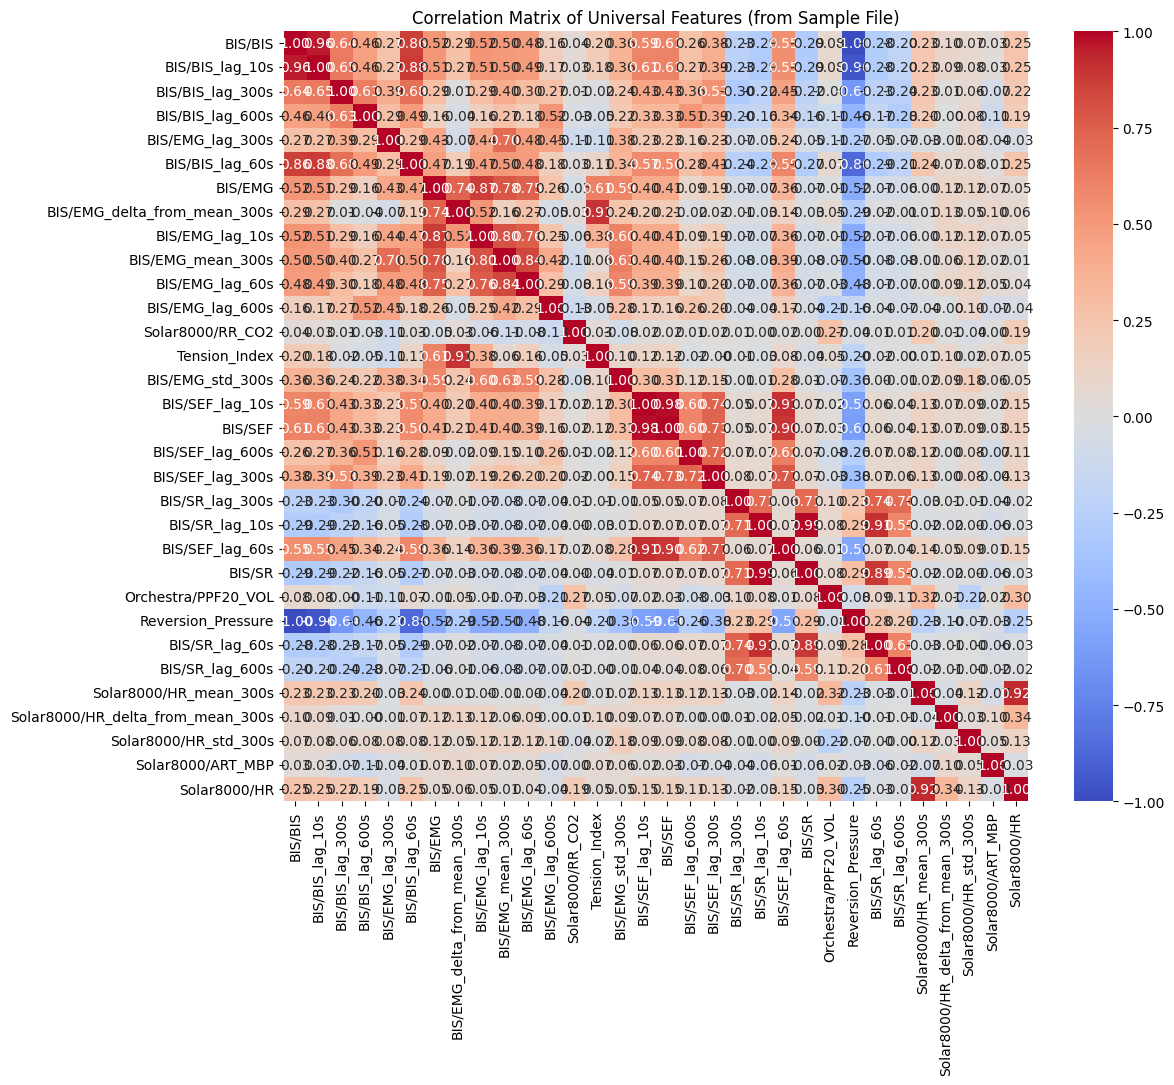



--- DATA RECONNAISSANCE COMPLETE ---


In [ ]:
# --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow tqdm matplotlib seaborn --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq # Import the necessary library

# --- Step 2: Mount Google Drive and Define Paths ---
print("\n--- Mounting Google Drive ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # IMPORTANT: Please verify this path matches your folder structure in Google Drive
    DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
    BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
    print(f"--- Target directory set to: {BATCH_DIR_PATH} ---")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")
    BATCH_DIR_PATH = '.' # Fallback to current directory if not in Colab

# --- Step 3: Discover and Count Batch Files ---
print("\n--- Discovering batch files... ---")
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No batch files found in '{BATCH_DIR_PATH}'. Please check the path.")
total_files = len(batch_files)
print(f"--- Found {total_files} batch files to analyze. ---")


# --- Step 4: Perform a Comprehensive Feature Census (CORRECTED) ---
print("\n--- Starting Feature Census (Phase 1)... ---")
feature_counts = Counter()
schema_counts = Counter()

for file_path in tqdm(batch_files, desc="Analyzing file schemas"):
    try:
        # THE FIX: Use pyarrow to read only the schema metadata efficiently.
        schema = pq.read_schema(file_path)
        columns = tuple(sorted(schema.names)) # Use a sorted tuple as a key

        feature_counts.update(columns)
        schema_counts[columns] += 1
    except Exception as e:
        print(f"\nCould not process file: {file_path}. Error: {e}")

print("--- Feature Census complete. ---")


# --- Step 5: Analyze and Display Census Results ---
print("\n\n--- CENSUS ANALYSIS ---")
print("=======================")

# 5.1: Schema Heterogeneity Analysis
num_unique_schemas = len(schema_counts)
print(f"\n1. Schema Heterogeneity:")
print(f"   - Total Files Analyzed: {total_files}")
print(f"   - Number of Unique Schemas (column sets): {num_unique_schemas}")
if num_unique_schemas > 1:
    print("   - DIAGNOSIS: The dataset is HETEROGENEOUS. Different files have different sets of columns.")
    # Print the top 5 most common schemas
    print("\n   Top 5 Most Common Schemas (by file count):")
    for i, (schema, count) in enumerate(schema_counts.most_common(5)):
        print(f"     {i+1}. Count: {count} files ({count/total_files:.1%}), Columns: {len(schema)}")
else:
    print("   - DIAGNOSIS: The dataset is HOMOGENEOUS. All files share the same column structure.")


# 5.2: Feature Availability Analysis
print("\n2. Feature Availability (The Universal Feature List):")
feature_availability = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['FileCount'])
feature_availability['Availability (%)'] = (feature_availability['FileCount'] / total_files) * 100
feature_availability = feature_availability.sort_values(by='FileCount', ascending=False)

# Identify Universal, Common, and Rare features
UNIVERSAL_THRESHOLD = 95.0
COMMON_THRESHOLD = 50.0

feature_availability['Category'] = 'Rare'
feature_availability.loc[feature_availability['Availability (%)'] >= COMMON_THRESHOLD, 'Category'] = 'Common'
feature_availability.loc[feature_availability['Availability (%)'] >= UNIVERSAL_THRESHOLD, 'Category'] = 'Universal'

pd.set_option('display.max_rows', 200) # Ensure we see all features
print(feature_availability)

universal_features = feature_availability[feature_availability['Category'] == 'Universal'].index.tolist()
print("\n--- IDENTIFIED UNIVERSAL FEATURES (>95% Availability) ---")
print(universal_features)
print("----------------------------------------------------")


# --- Step 6: Initial Profiling of Universal Features ---
print("\n\n--- INITIAL DATA PROFILING (from a sample file) ---")
print("=====================================================")
# We will load one file to do a quick check on the data quality of our new trusted feature set.
sample_file_path = batch_files[0]
print(f"Loading sample file for profiling: {sample_file_path}")
try:
    df_sample = pd.read_parquet(sample_file_path)

    # Keep only the universal features for this analysis
    # We need to check which universal features are actually in this specific sample file
    available_universal_features = [f for f in universal_features if f in df_sample.columns]

    if not available_universal_features:
         print("WARNING: The sample file contains no universal features. Skipping profiling.")
    else:
        df_universal_sample = df_sample[available_universal_features]

        # 6.1: Descriptive Statistics
        print("\n1. Descriptive Statistics for Universal Features:")
        print(df_universal_sample.describe().T)

        # 6.2: Correlation Matrix
        print("\n2. Correlation Matrix for Universal Features:")

        # Calculate correlation matrix
        corr_matrix = df_universal_sample.corr()

        # Plotting the heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Universal Features (from Sample File)')
        plt.show()

except Exception as e:
    print(f"\nCould not load or profile the sample file. Error: {e}")

print("\n\n--- DATA RECONNAISSANCE COMPLETE ---")

In [ ]:
# --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow tqdm --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm

# --- Step 2: Mount Google Drive and Define Paths ---
print("\n--- Mounting Google Drive ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
    SOURCE_BATCH_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
    DEST_FEATURE_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'featured_batches')
    os.makedirs(DEST_FEATURE_DIR, exist_ok=True)
    print(f"--- Source directory: {SOURCE_BATCH_DIR} ---")
    print(f"--- Destination directory: {DEST_FEATURE_DIR} ---")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")
    SOURCE_BATCH_DIR = '.'
    DEST_FEATURE_DIR = './featured_batches'
    os.makedirs(DEST_FEATURE_DIR, exist_ok=True)

# --- Step 3: Define the Universal Feature Set (from our census) ---
UNIVERSAL_FEATURES = [
    'BIS/BIS', 'BIS/BIS_lag_10s', 'BIS/BIS_lag_300s', 'BIS/BIS_lag_600s',
    'BIS/EMG_lag_300s', 'BIS/BIS_lag_60s', 'BIS/EMG', 'BIS/EMG_delta_from_mean_300s',
    'BIS/EMG_lag_10s', 'BIS/EMG_mean_300s', 'BIS/EMG_lag_60s', 'BIS/EMG_lag_600s',
    'Solar8000/RR_CO2', 'Tension_Index', 'BIS/EMG_std_300s', 'BIS/SEF_lag_10s',
    'BIS/SEF', 'BIS/SEF_lag_600s', 'BIS/SEF_lag_300s', 'BIS/SR_lag_300s',
    'BIS/SR_lag_10s', 'BIS/SEF_lag_60s', 'BIS/SR', 'Orchestra/PPF20_VOL',
    'Reversion_Pressure', 'BIS/SR_lag_60s', 'BIS/SR_lag_600s',
    'Solar8000/HR_mean_300s', 'Solar8000/HR_delta_from_mean_300s',
    'Solar8000/HR_std_300s', 'Solar8000/ART_MBP', 'Solar8000/HR'
]
# Note: 'patient_id' and 'Time' will be handled explicitly.

# --- Step 4: The Feature Engineering Pipeline ---
print("\n--- Starting Feature Engineering Pipeline ---")

source_files = sorted(glob.glob(os.path.join(SOURCE_BATCH_DIR, 'batch_*.parquet')))

for file_path in tqdm(source_files, desc="Engineering features from batches"):
    try:
        df = pd.read_parquet(file_path)

        # --- THE FIX: Ensure 'patient_id' and 'Time' are columns ---
        # This moves any index levels (like 'patient_id' or 'Time') into columns.
        # If they are already columns, this does nothing. This makes the script robust.
        df = df.reset_index()

        # --- Phase 1: Select only Universal Features ---
        features_to_load = [f for f in UNIVERSAL_FEATURES if f in df.columns]
        # We also need patient_id for grouping
        df_universal = df[features_to_load + ['patient_id']].copy()

        # --- Phase 2: Intelligent Imputation (per patient) ---
        # Group by patient and forward-fill. This is critical.
        df_universal = df_universal.groupby('patient_id').transform(lambda x: x.ffill().bfill())
        df_universal.fillna(0, inplace=True) # Final fallback for any fully-NaN columns per patient

        # --- Phase 3: Create Advanced, Domain-Informed Features ---
        df_universal['HR_volatility_300s'] = df_universal['Solar8000/HR'].rolling(window=300, min_periods=1).std()
        df_universal['MBP_volatility_300s'] = df_universal['Solar8000/ART_MBP'].rolling(window=300, min_periods=1).std()
        df_universal['BIS_grad_1min'] = df_universal['BIS/BIS'].diff(periods=60)
        df_universal['MBP_grad_1min'] = df_universal['Solar8000/ART_MBP'].diff(periods=60)

        # Add a small epsilon to avoid division by zero
        epsilon = 1e-6
        df_universal['Shock_Index_Proxy'] = df_universal['Solar8000/HR'] / (df_universal['Solar8000/ART_MBP'] + epsilon)

        ppf_rate = df_universal['Orchestra/PPF20_VOL'].diff()
        df_universal['BIS_per_PPF_rate'] = df_universal['BIS/BIS'].diff() / (ppf_rate + epsilon)

        df_universal.replace([np.inf, -np.inf], 0, inplace=True)
        df_universal.fillna(0, inplace=True)

        # --- Phase 4: Select Final Feature Set for Modeling ---
        final_features = [
            'BIS/BIS',
            'BIS/EMG',
            'BIS/SEF',
            'BIS/SR',
            'Solar8000/HR',
            'Solar8000/ART_MBP',
            'Orchestra/PPF20_VOL',
            'Tension_Index',
            'Reversion_Pressure',
            'HR_volatility_300s',
            'MBP_volatility_300s',
            'BIS_grad_1min',
            'MBP_grad_1min',
            'Shock_Index_Proxy',
            'BIS_per_PPF_rate'
        ]

        # Re-add the patient_id from the original dataframe's index/column
        final_df = df_universal[final_features].copy()
        final_df['patient_id'] = df['patient_id']

        # --- Save the new engineered dataframe ---
        base_filename = os.path.basename(file_path)
        dest_path = os.path.join(DEST_FEATURE_DIR, base_filename)
        final_df.to_parquet(dest_path, index=False)

    except Exception as e:
        print(f"\nERROR processing file {file_path}: {e}")
        # If there's an error, we want to know why.
        import traceback
        traceback.print_exc()


print("\n\n--- FEATURE ENGINEERING COMPLETE ---")
print(f"--- All engineered feature files have been saved to: {DEST_FEATURE_DIR} ---")

--- Installing necessary libraries ---
--- Libraries installed successfully. ---

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Source directory: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
--- Destination directory: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/featured_batches ---

--- Starting Feature Engineering Pipeline ---


Engineering features from batches:   0%|          | 0/64 [00:00<?, ?it/s]



--- FEATURE ENGINEERING COMPLETE ---
--- All engineered feature files have been saved to: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/featured_batches ---


--- Installing necessary libraries ---
--- Libraries installed successfully. ---

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading engineered data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/featured_batches ---

--- Performing patient-aware split... ---
Split into 4449 training patients and 1113 validation patients.

--- Starting MEMORY-SAFE Incremental Training ---


Incremental Training:   0%|          | 0/64 [00:00<?, ?it/s]

--- Incremental training complete. ---
Final model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_engineered_lgbm_model.joblib

--- Predicting on Validation Set... ---


Predicting on Validation Set:   0%|          | 0/64 [00:00<?, ?it/s]


--- Final Evaluation ---

--- FINAL CLASSIFICATION REPORT (with Engineered Features) ---
               precision    recall  f1-score   support

       Stable       0.62      0.85      0.71   6612345
  Drifting Up       0.42      0.19      0.27   2421872
Drifting Down       0.45      0.22      0.29   2320272

     accuracy                           0.58  11354489
    macro avg       0.49      0.42      0.42  11354489
 weighted avg       0.54      0.58      0.53  11354489


--- FINAL CONFUSION MATRIX (with Engineered Features) ---


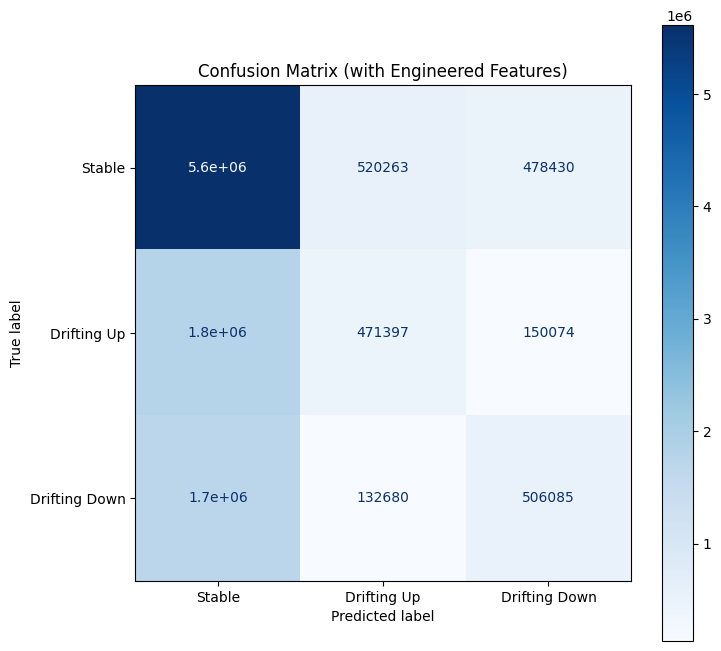

In [ ]:
# --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow lightgbm scikit-learn matplotlib seaborn --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

# --- Step 2: Mount Google Drive and Define Paths ---
print("\n--- Mounting Google Drive ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
    FEATURE_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'featured_batches')
    MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_engineered_lgbm_model.joblib')
    print(f"--- Loading engineered data from: {FEATURE_DIR_PATH} ---")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")
    FEATURE_DIR_PATH = './featured_batches'
    MODEL_SAVE_PATH = './final_engineered_lgbm_model.joblib'

# --- Step 3: Patient-Aware Train-Validation Split (on IDs only) ---
print("\n--- Performing patient-aware split... ---")
feature_files = sorted(glob.glob(os.path.join(FEATURE_DIR_PATH, 'batch_*.parquet')))
if not feature_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No engineered feature files found in '{FEATURE_DIR_PATH}'.")

# Get all unique patient IDs without loading all data
all_pids = pd.concat([pd.read_parquet(f, columns=['patient_id']) for f in feature_files])['patient_id'].unique()
train_pids, val_pids = train_test_split(all_pids, test_size=0.2, random_state=42)
train_pids_set = set(train_pids)
val_pids_set = set(val_pids)
print(f"Split into {len(train_pids_set)} training patients and {len(val_pids_set)} validation patients.")


# --- Step 4: Incremental Training on Engineered Features ---
print("\n--- Starting MEMORY-SAFE Incremental Training ---")
booster = None # Initialize the model as empty

for file_path in tqdm(feature_files, desc="Incremental Training"):
    df_chunk = pd.read_parquet(file_path)

    # Filter for training patients only
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_pids_set)].copy()
    if train_chunk.empty:
        continue

    # --- Create Target Variable within the chunk ---
    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    train_chunk['drift_class'] = 0
    train_chunk.loc[train_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    train_chunk.loc[train_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    # Prepare X and y for this chunk
    X_train_chunk = train_chunk.drop(columns=['patient_id', 'BIS_future_30s', 'BIS_drift_30s', 'drift_class'])
    y_train_chunk = train_chunk['drift_class']

    # Create LightGBM dataset
    lgb_train = lgb.Dataset(X_train_chunk, y_train_chunk)

    # THE KEY TO INCREMENTAL TRAINING:
    # Pass the existing model to init_model to continue training.
    booster = lgb.train(
        params={'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss', 'random_state': 42, 'n_jobs': -1, 'verbose': -1},
        train_set=lgb_train,
        num_boost_round=10, # Train for a few rounds on each chunk
        init_model=booster
    )

print("--- Incremental training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final model saved to {MODEL_SAVE_PATH}")


# --- Step 5: Incremental Prediction on Validation Set ---
print("\n--- Predicting on Validation Set... ---")
all_y_val = []
all_preds = []

for file_path in tqdm(feature_files, desc="Predicting on Validation Set"):
    df_chunk = pd.read_parquet(file_path)

    # Filter for validation patients only
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_pids_set)].copy()
    if val_chunk.empty:
        continue

    # Replicate the same target creation logic
    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    val_chunk['drift_class'] = 0
    val_chunk.loc[val_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    val_chunk.loc[val_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_val_chunk = val_chunk.drop(columns=['patient_id', 'BIS_future_30s', 'BIS_drift_30s', 'drift_class'])
    y_val_chunk = val_chunk['drift_class']

    # Make predictions on this chunk
    preds_proba = booster.predict(X_val_chunk)
    preds_class = np.argmax(preds_proba, axis=1)

    all_y_val.append(y_val_chunk)
    all_preds.append(preds_class)

# --- Step 6: Final Evaluation ---
print("\n--- Final Evaluation ---")
y_val_computed = pd.concat(all_y_val)
preds_computed = np.concatenate(all_preds)

print("\n--- FINAL CLASSIFICATION REPORT (with Engineered Features) ---")
print(classification_report(y_val_computed, preds_computed, target_names=['Stable', 'Drifting Up', 'Drifting Down']))

print("\n--- FINAL CONFUSION MATRIX (with Engineered Features) ---")
cm = confusion_matrix(y_val_computed, preds_computed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Drifting Up', 'Drifting Down'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix (with Engineered Features)")
plt.show()

--- Installing necessary libraries ---
--- Libraries installed successfully. ---

--- Mounting Google Drive ---
Mounted at /content/drive
--- Loading engineered data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/featured_batches ---

--- Performing patient-aware split... ---
Split into 4449 training patients and 1113 validation patients.

--- Starting Final Training with In-Loop SMOTE Balancing ---


Incremental Training with SMOTE:   0%|          | 0/64 [00:00<?, ?it/s]

--- Final training complete. ---
Final model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_SMOTE_engineered_model.joblib

--- Predicting on Validation Set... ---


Predicting on Validation Set:   0%|          | 0/64 [00:00<?, ?it/s]


--- Final Evaluation ---

--- FINAL CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

       Stable       0.65      0.59      0.62   6612345
  Drifting Up       0.35      0.39      0.37   2421872
Drifting Down       0.37      0.42      0.39   2320272

     accuracy                           0.52  11354489
    macro avg       0.46      0.47      0.46  11354489
 weighted avg       0.53      0.52      0.52  11354489


--- FINAL CONFUSION MATRIX ---


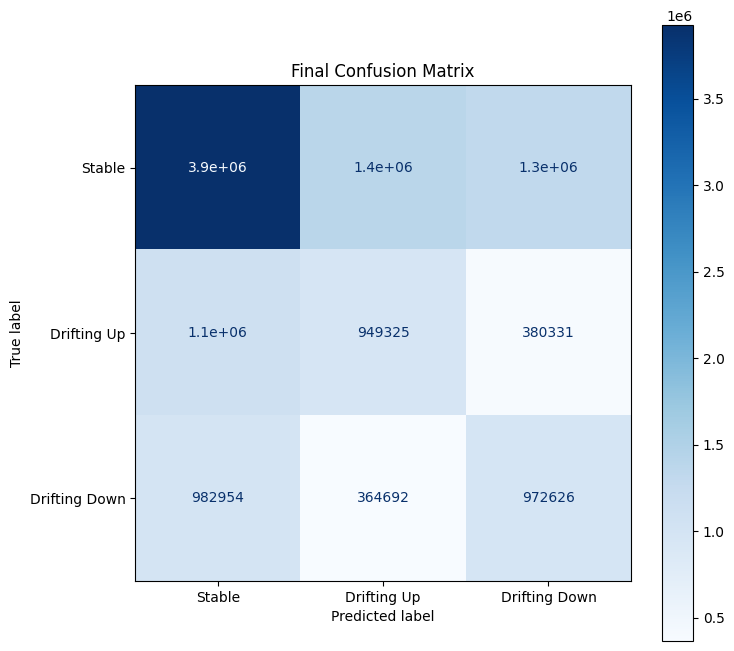

In [ ]:
 # --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow lightgbm scikit-learn matplotlib seaborn imbalanced-learn --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

# --- Step 2: Mount Google Drive and Define Paths ---
print("\n--- Mounting Google Drive ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
    FEATURE_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'featured_batches')
    MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_SMOTE_engineered_model.joblib')
    print(f"--- Loading engineered data from: {FEATURE_DIR_PATH} ---")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")
    FEATURE_DIR_PATH = './featured_batches'
    MODEL_SAVE_PATH = './final_SMOTE_engineered_model.joblib'

# --- Step 3: Patient-Aware Train-Validation Split (on IDs only) ---
print("\n--- Performing patient-aware split... ---")
feature_files = sorted(glob.glob(os.path.join(FEATURE_DIR_PATH, 'batch_*.parquet')))
if not feature_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No engineered feature files found in '{FEATURE_DIR_PATH}'.")

all_pids = pd.concat([pd.read_parquet(f, columns=['patient_id']) for f in feature_files])['patient_id'].unique()
train_pids, val_pids = train_test_split(all_pids, test_size=0.2, random_state=42)
train_pids_set = set(train_pids)
val_pids_set = set(val_pids)
print(f"Split into {len(train_pids_set)} training patients and {len(val_pids_set)} validation patients.")


# --- Step 4: The Final Training Loop with SMOTE ---
print("\n--- Starting Final Training with In-Loop SMOTE Balancing ---")
booster = None
# THE FIX: The SMOTE library does not accept the n_jobs argument. It has been removed.
smote = SMOTE(random_state=42)

for file_path in tqdm(feature_files, desc="Incremental Training with SMOTE"):
    df_chunk = pd.read_parquet(file_path)
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_pids_set)].copy()
    if train_chunk.empty: continue

    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    train_chunk['drift_class'] = 0
    train_chunk.loc[train_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    train_chunk.loc[train_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_train_chunk = train_chunk.drop(columns=['patient_id', 'BIS_future_30s', 'BIS_drift_30s', 'drift_class'])
    y_train_chunk = train_chunk['drift_class']

    if y_train_chunk.nunique() > 1:
        X_resampled, y_resampled = smote.fit_resample(X_train_chunk, y_train_chunk)
    else:
        X_resampled, y_resampled = X_train_chunk, y_train_chunk

    lgb_train = lgb.Dataset(X_resampled, y_resampled)

    booster = lgb.train(
        params={'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss', 'random_state': 42, 'n_jobs': -1, 'verbose': -1},
        train_set=lgb_train,
        num_boost_round=20,
        init_model=booster
    )

print("--- Final training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final model saved to {MODEL_SAVE_PATH}")


# --- Step 5: Incremental Prediction ---
print("\n--- Predicting on Validation Set... ---")
all_y_val = []
all_preds = []

for file_path in tqdm(feature_files, desc="Predicting on Validation Set"):
    df_chunk = pd.read_parquet(file_path)
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_pids_set)].copy()
    if val_chunk.empty: continue

    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    val_chunk['drift_class'] = 0
    val_chunk.loc[val_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    val_chunk.loc[val_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_val_chunk = val_chunk.drop(columns=['patient_id', 'BIS_future_30s', 'BIS_drift_30s', 'drift_class'])
    y_val_chunk = val_chunk['drift_class']

    preds_proba = booster.predict(X_val_chunk)
    preds_class = np.argmax(preds_proba, axis=1)

    all_y_val.append(y_val_chunk)
    all_preds.append(preds_class)

# --- Step 6: Final Evaluation ---
print("\n--- Final Evaluation ---")
y_val_computed = pd.concat(all_y_val)
preds_computed = np.concatenate(all_preds)

print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_val_computed, preds_computed, target_names=['Stable', 'Drifting Up', 'Drifting Down']))

print("\n--- FINAL CONFUSION MATRIX ---")
cm = confusion_matrix(y_val_computed, preds_computed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Drifting Up', 'Drifting Down'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Final Confusion Matrix")
plt.show()

--- Installing necessary libraries ---
--- Libraries installed successfully. ---

--- Mounting Google Drive and Loading Assets ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading final model from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_SMOTE_engineered_model.joblib ---
--- Model loaded successfully. ---

--- Selecting a single patient for visualization... ---
--- Target Patient ID for visualization: 2205 ---
--- Found 6872 data points for the selected patient. ---
--- Generating predictions for the patient's timeline... ---
--- Creating the final visualization... ---


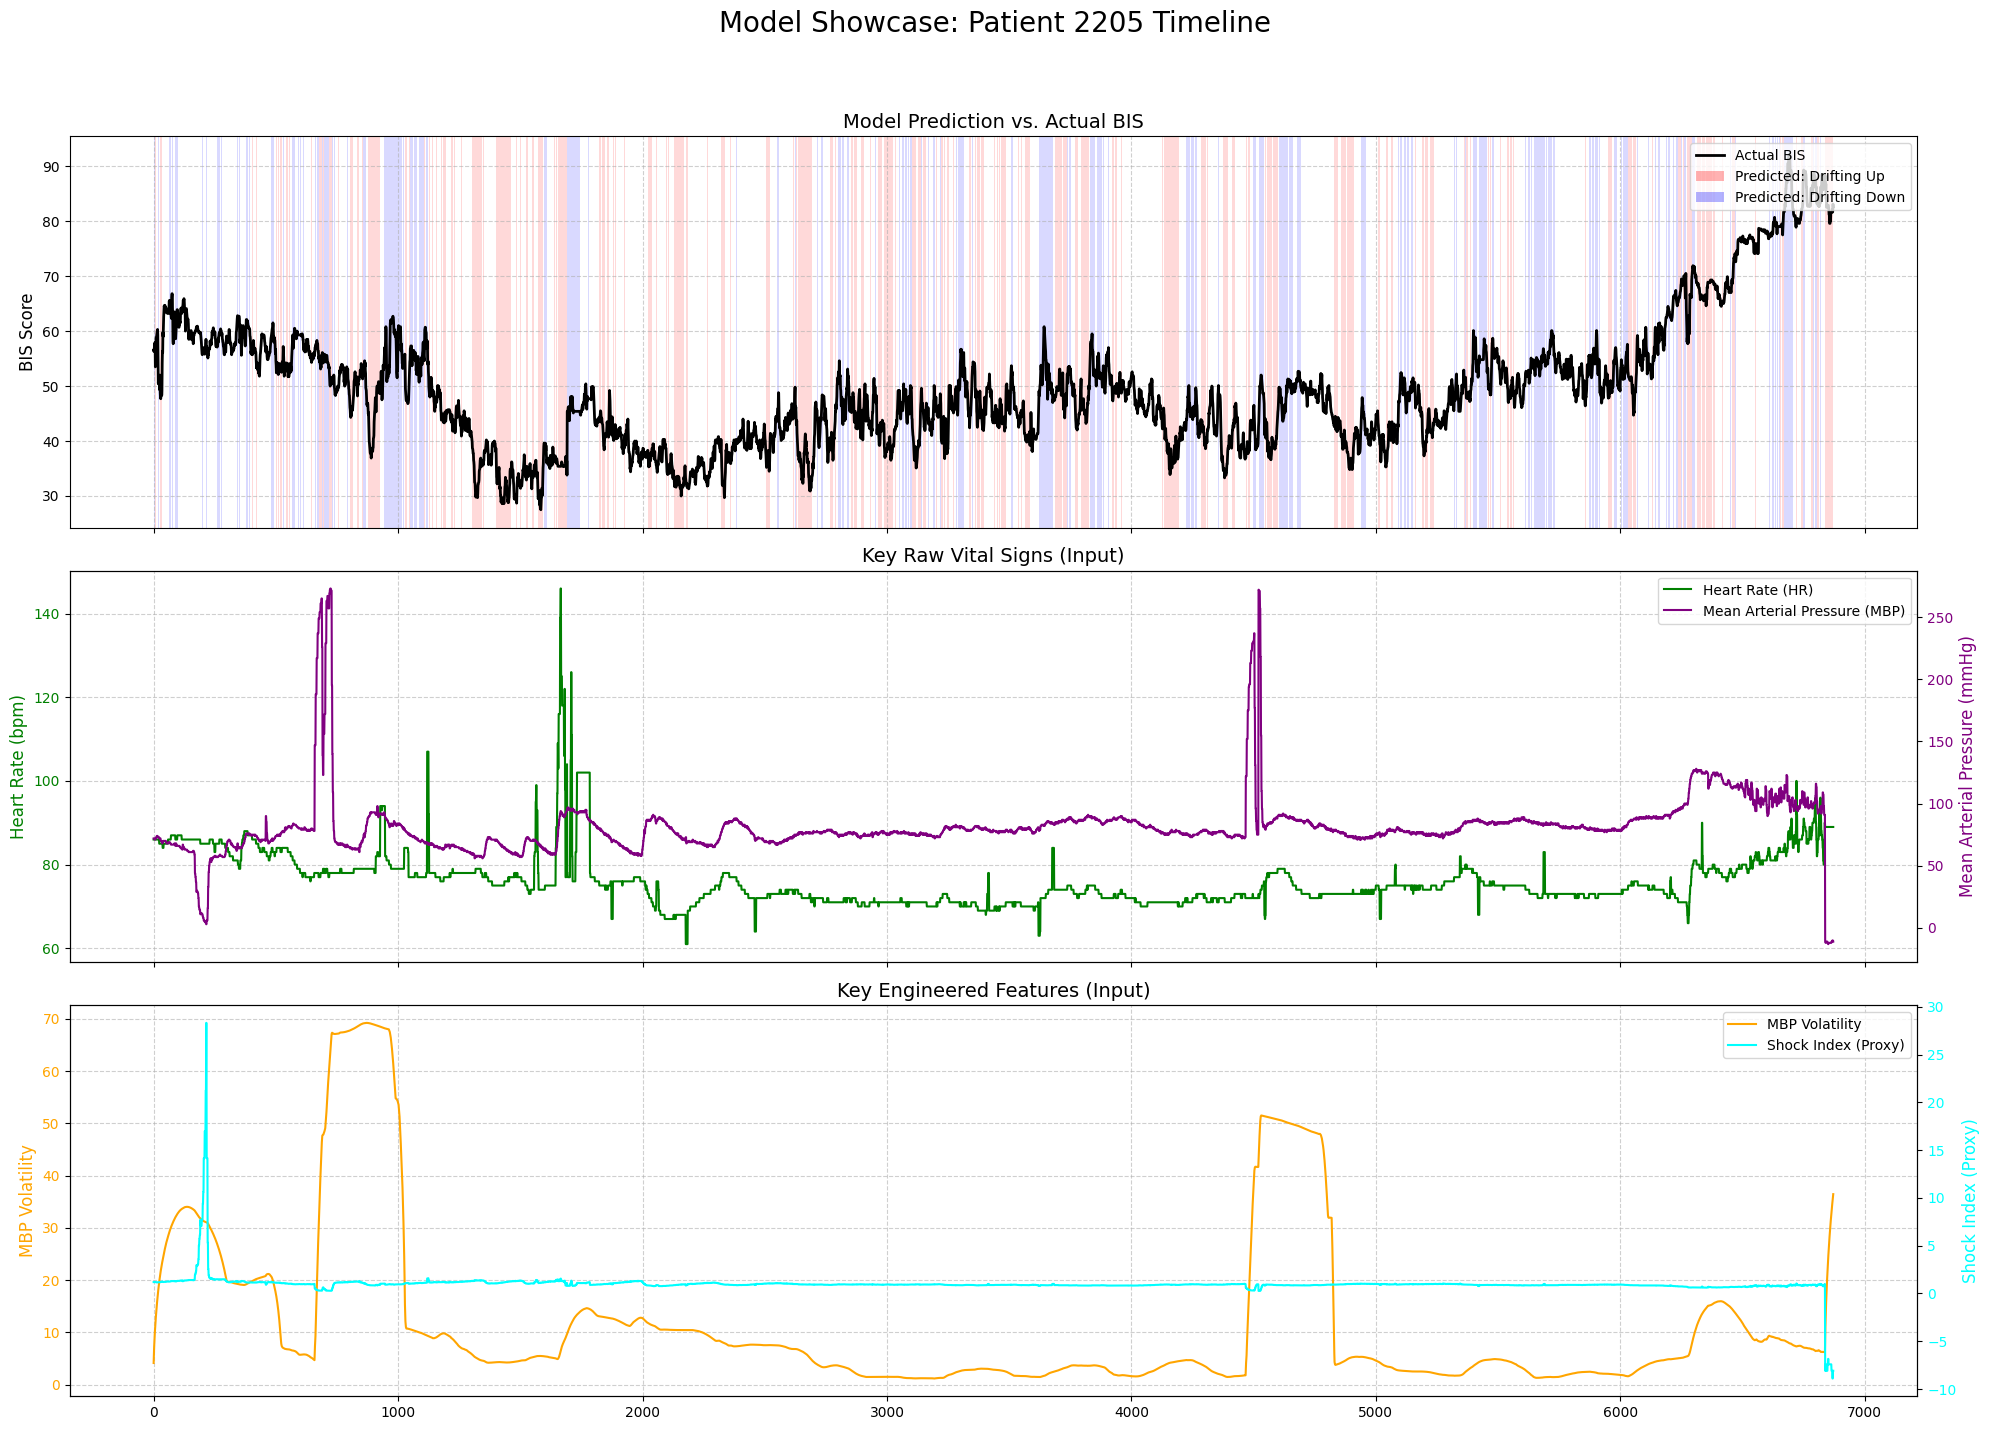

In [ ]:
# --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow lightgbm scikit-learn matplotlib seaborn --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

# --- Step 2: Mount Google Drive and Load Final Model ---
print("\n--- Mounting Google Drive and Loading Assets ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
    FEATURE_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'featured_batches')
    # IMPORTANT: This path must match the final saved model from the training script
    MODEL_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_SMOTE_engineered_model.joblib')

    print(f"--- Loading final model from: {MODEL_PATH} ---")
    model = joblib.load(MODEL_PATH)
    print("--- Model loaded successfully. ---")

except Exception as e:
    raise FileNotFoundError(f"CRITICAL ERROR: Could not load the final model. Please ensure the training script completed and the path is correct. Error: {e}")

# --- Step 3: Select and Prepare Data for a Single Patient ---
print("\n--- Selecting a single patient for visualization... ---")
feature_files = sorted(glob.glob(os.path.join(FEATURE_DIR_PATH, 'batch_*.parquet')))
if not feature_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No engineered feature files found.")

# Get the list of validation patient IDs to choose from
all_pids = pd.concat([pd.read_parquet(f, columns=['patient_id']) for f in feature_files])['patient_id'].unique()
_, val_pids = train_test_split(all_pids, test_size=0.2, random_state=42)

# Let's select a patient to visualize. We can change this ID later.
TARGET_PATIENT_ID = val_pids[5]
print(f"--- Target Patient ID for visualization: {TARGET_PATIENT_ID} ---")

# Load all data for this single patient
patient_df_list = [pd.read_parquet(f) for f in feature_files]
master_df = pd.concat(patient_df_list, ignore_index=True)
patient_df = master_df[master_df['patient_id'] == TARGET_PATIENT_ID].copy()
patient_df.sort_index(inplace=True) # Ensure data is in chronological order

print(f"--- Found {len(patient_df)} data points for the selected patient. ---")


# --- Step 4: Generate Predictions for the Patient ---
print("--- Generating predictions for the patient's timeline... ---")

# Define the feature set the model was trained on
FEATURES = [
    'BIS/BIS', 'BIS/EMG', 'BIS/SEF', 'BIS/SR', 'Solar8000/HR',
    'Solar8000/ART_MBP', 'Orchestra/PPF20_VOL', 'Tension_Index',
    'Reversion_Pressure', 'HR_volatility_300s', 'MBP_volatility_300s',
    'BIS_grad_1min', 'MBP_grad_1min', 'Shock_Index_Proxy', 'BIS_per_PPF_rate'
]

X_patient = patient_df[FEATURES]

# Predict probabilities and then the final class
predictions_proba = model.predict(X_patient)
predictions_class = np.argmax(predictions_proba, axis=1)
patient_df['predicted_class'] = predictions_class


# --- Step 5: Generate the Showcase Plot ---
print("--- Creating the final visualization... ---")

# Create a time axis for plotting (assuming 1 row = 1 second)
time_axis = np.arange(len(patient_df))

fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
fig.suptitle(f'Model Showcase: Patient {TARGET_PATIENT_ID} Timeline', fontsize=20)

# --- Panel 1: The Prediction and Ground Truth ---
ax1 = axes[0]
ax1.plot(time_axis, patient_df['BIS/BIS'], label='Actual BIS', color='black', linewidth=2)
ax1.set_ylabel('BIS Score', fontsize=12)
ax1.set_title('Model Prediction vs. Actual BIS', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)

# Add colored background shading for the model's predictions
# Red for "Drifting Up", Blue for "Drifting Down"
for i in range(len(patient_df)):
    if patient_df['predicted_class'].iloc[i] == 1: # Drifting Up
        ax1.axvspan(i, i+1, color='red', alpha=0.15, lw=0)
    elif patient_df['predicted_class'].iloc[i] == 2: # Drifting Down
        ax1.axvspan(i, i+1, color='blue', alpha=0.15, lw=0)

# Create custom legend patches for the background colors
from matplotlib.patches import Patch
legend_elements = [plt.Line2D([0], [0], color='black', lw=2, label='Actual BIS'),
                   Patch(facecolor='red', alpha=0.3, label='Predicted: Drifting Up'),
                   Patch(facecolor='blue', alpha=0.3, label='Predicted: Drifting Down')]
ax1.legend(handles=legend_elements, loc='upper right')


# --- Panel 2: Key Raw Vitals the Model Sees ---
ax2 = axes[1]
ax2.set_title('Key Raw Vital Signs (Input)', fontsize=14)
ax2_twin = ax2.twinx() # Create a second y-axis

p1, = ax2.plot(time_axis, patient_df['Solar8000/HR'], color='green', label='Heart Rate (HR)')
ax2.set_ylabel('Heart Rate (bpm)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

p2, = ax2_twin.plot(time_axis, patient_df['Solar8000/ART_MBP'], color='purple', label='Mean Arterial Pressure (MBP)')
ax2_twin.set_ylabel('Mean Arterial Pressure (mmHg)', color='purple', fontsize=12)
ax2_twin.tick_params(axis='y', labelcolor='purple')

ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(handles=[p1, p2], loc='upper right')


# --- Panel 3: Key Engineered Features the Model Sees ---
ax3 = axes[2]
ax3.set_title('Key Engineered Features (Input)', fontsize=14)
ax3_twin = ax3.twinx()

p3, = ax3.plot(time_axis, patient_df['MBP_volatility_300s'], color='orange', label='MBP Volatility')
ax3.set_ylabel('MBP Volatility', color='orange', fontsize=12)
ax3.tick_params(axis='y', labelcolor='orange')

p4, = ax3_twin.plot(time_axis, patient_df['Shock_Index_Proxy'], color='cyan', label='Shock Index (Proxy)')
ax3_twin.set_ylabel('Shock Index (Proxy)', color='cyan', fontsize=12)
ax3_twin.tick_params(axis='y', labelcolor='cyan')

ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend(handles=[p3, p4], loc='upper right')

plt.xlabel('Time (seconds)', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

In [ ]:
# --- Step 1: Setup and Installation ---
print("--- Installing necessary libraries ---")
!pip install pandas numpy pyarrow lightgbm scikit-learn matplotlib seaborn --quiet
print("--- Libraries installed successfully. ---")

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib

# --- Step 2: Mount Google Drive and Define Paths ---
print("\n--- Mounting Google Drive ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
    FEATURE_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'featured_batches')
    MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_virtual_bis_regressor.joblib')
    print(f"--- Loading engineered data from: {FEATURE_DIR_PATH} ---")
except Exception as e:
    raise IOError(f"Could not mount/access Google Drive. Error: {e}")

# --- Step 3: Patient-Aware Train-Validation Split (on IDs only) ---
print("\n--- Performing patient-aware split... ---")
feature_files = sorted(glob.glob(os.path.join(FEATURE_DIR_PATH, 'batch_*.parquet')))
if not feature_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No engineered feature files found.")

all_pids = pd.concat([pd.read_parquet(f, columns=['patient_id']) for f in feature_files])['patient_id'].unique()
train_pids, val_pids = train_test_split(all_pids, test_size=0.2, random_state=42)
train_pids_set = set(train_pids)
val_pids_set = set(val_pids)
print(f"Split into {len(train_pids_set)} training patients and {len(val_pids_set)} validation patients.")

# --- Step 4: Define the Strict Feature Set ---
# This is the most important rule of this experiment.
FORBIDDEN_FEATURES = ['BIS/BIS', 'BIS/EMG', 'BIS/SEF', 'BIS/SR', 'BIS_grad_1min', 'BIS_per_PPF_rate']
# We must exclude the target AND all other features derived from the BIS monitor.

--- Installing necessary libraries ---
--- Libraries installed successfully. ---

--- Mounting Google Drive ---
Mounted at /content/drive
--- Loading engineered data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/featured_batches ---

--- Performing patient-aware split... ---
Split into 4449 training patients and 1113 validation patients.


In [ ]:
# --- Step 5: Incremental Training for the Regressor ---
print("\n--- Starting Incremental Training for 'Virtual BIS' Regressor ---")
booster = None

for file_path in tqdm(feature_files, desc="Incremental Training"):
    df_chunk = pd.read_parquet(file_path)
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_pids_set)].copy()
    if train_chunk.empty: continue

    # The target (y) is the current BIS score.
    y_train_chunk = train_chunk['BIS/BIS']
    # The features (X) are everything EXCEPT the forbidden ones.
    X_train_chunk = train_chunk.drop(columns=['patient_id'] + FORBIDDEN_FEATURES)

    lgb_train = lgb.Dataset(X_train_chunk, y_train_chunk)

    booster = lgb.train(
        params={'objective': 'regression_l1', 'metric': 'mae', 'random_state': 42, 'n_jobs': -1, 'verbose': -1},
        train_set=lgb_train,
        num_boost_round=10,
        init_model=booster
    )

print("--- Incremental training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final regressor model saved to {MODEL_SAVE_PATH}")


--- Starting Incremental Training for 'Virtual BIS' Regressor ---


Incremental Training:   0%|          | 0/64 [00:00<?, ?it/s]

--- Incremental training complete. ---
Final regressor model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_virtual_bis_regressor.joblib



--- Predicting on Validation Set... ---


Predicting on Validation Set:   0%|          | 0/64 [00:00<?, ?it/s]


--- Final Evaluation ---

--- FINAL REGRESSION REPORT ('Virtual BIS' Model) ---
  Mean Absolute Error (MAE): 0.0683
  Mean Squared Error (MSE):  0.0319
  R-squared (R²):            0.9998
----------------------------------------------------


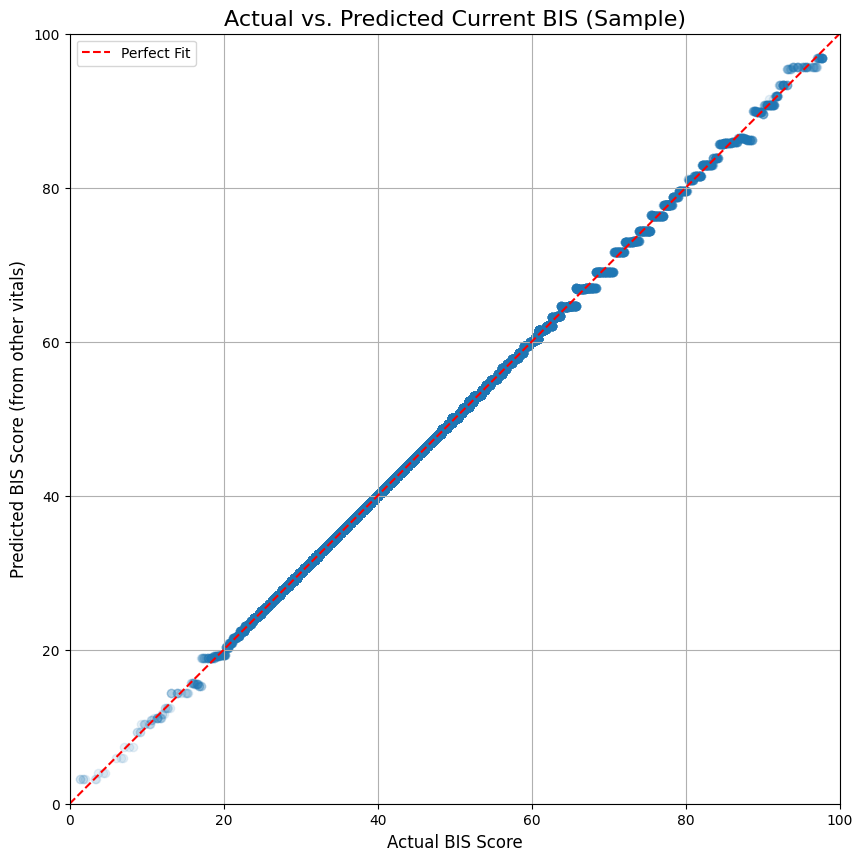

In [ ]:
# --- Step 6: Incremental Prediction on Validation Set ---
print("\n--- Predicting on Validation Set... ---")
all_y_true = []
all_y_pred = []

for file_path in tqdm(feature_files, desc="Predicting on Validation Set"):
    df_chunk = pd.read_parquet(file_path)
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_pids_set)].copy()
    if val_chunk.empty: continue

    y_true_chunk = val_chunk['BIS/BIS']
    X_val_chunk = val_chunk.drop(columns=['patient_id'] + FORBIDDEN_FEATURES)

    preds = booster.predict(X_val_chunk)

    all_y_true.append(y_true_chunk)
    all_y_pred.append(preds)

# --- Step 7: Final Evaluation ---
print("\n--- Final Evaluation ---")
y_true = pd.concat(all_y_true)
y_pred = np.concatenate(all_y_pred)

print("\n--- FINAL REGRESSION REPORT ('Virtual BIS' Model) ---")
print(f"  Mean Absolute Error (MAE): {mean_absolute_error(y_true, y_pred):.4f}")
print(f"  Mean Squared Error (MSE):  {mean_squared_error(y_true, y_pred):.4f}")
print(f"  R-squared (R²):            {r2_score(y_true, y_pred):.4f}")
print("----------------------------------------------------")

# --- Plotting Actual vs. Predicted ---
plt.figure(figsize=(10, 10))
# Use a smaller sample for the scatter plot to avoid overplotting
sample_indices = np.random.choice(len(y_true), size=50000, replace=False)
plt.scatter(y_true.iloc[sample_indices], y_pred[sample_indices], alpha=0.1)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Perfect Fit')
plt.title('Actual vs. Predicted Current BIS (Sample)', fontsize=16)
plt.xlabel('Actual BIS Score', fontsize=12)
plt.ylabel('Predicted BIS Score (from other vitals)', fontsize=12)
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

---
